In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import kagglehub
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import load_model
from sklearn.utils import resample

In [2]:
# Download the datatset
path = kagglehub.dataset_download("nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone")

print("Path to dataset files:", path)

print("Available files:",os.listdir(path))

# Copy and store the dataset in the colab files
shutil.copy(path+'/'+'kidneyData.csv','/content/')
src=path+'/'+'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
shutil.copytree(src, '/content/', dirs_exist_ok=True)

100%|██████████| 1.52G/1.52G [00:08<00:00, 192MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone/versions/1
Available files: ['CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone', 'kidneyData.csv']


'/content/'

In [3]:
# Import the CSV file
df=pd.read_csv('/content/kidneyData.csv')
df.head()

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor


In [ ]:
# Obtaining the information in the CSV file
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12446 entries, 0 to 12445
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12446 non-null  int64 
 1   image_id    12446 non-null  object
 2   path        12446 non-null  object
 3   diag        12446 non-null  object
 4   target      12446 non-null  int64 
 5   Class       12446 non-null  object
dtypes: int64(2), object(4)
memory usage: 583.5+ KB


In [ ]:
# Count of missing values in each column
df.isnull().sum()

,0
Unnamed: 0,0
image_id,0
path,0
diag,0
target,0
Class,0


In [ ]:
# Count of categories present in 'Class' column
df['Class'].value_counts()

,count
Class,
Normal,5077
Cyst,3709
Tumor,2283
Stone,1377


In [ ]:
# Count of categories present in 'target' column
df['target'].value_counts()

,count
target,
1,5077
0,3709
3,2283
2,1377


In [ ]:
# Count of categories present in 'diag' column
df['diag'].value_counts()

,count
diag,
Normal,5077
Cyst,3709
Tumor,2283
Stone,1377


In [4]:
# Create a dataframe consisting the right path to the image and its label
base_dir = '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

sub_dirs = ['Tumor', 'Normal', 'Stone', 'Cyst']

data = []

for sub_dir in sub_dirs:
    sub_dir_path = os.path.join(base_dir, sub_dir)
    for image in os.listdir(sub_dir_path):
        if image.endswith('.jpg'):
            image_path = os.path.join(sub_dir_path, image)
            data.append({'image_path': image_path, 'label': sub_dir})

df=pd.concat([df,pd.DataFrame(data)],axis=1)

In [5]:
# Drop the columns that are not required
columns_to_drop=['Unnamed: 0','path','diag','Class']
df.drop(columns_to_drop,axis=1,inplace=True)

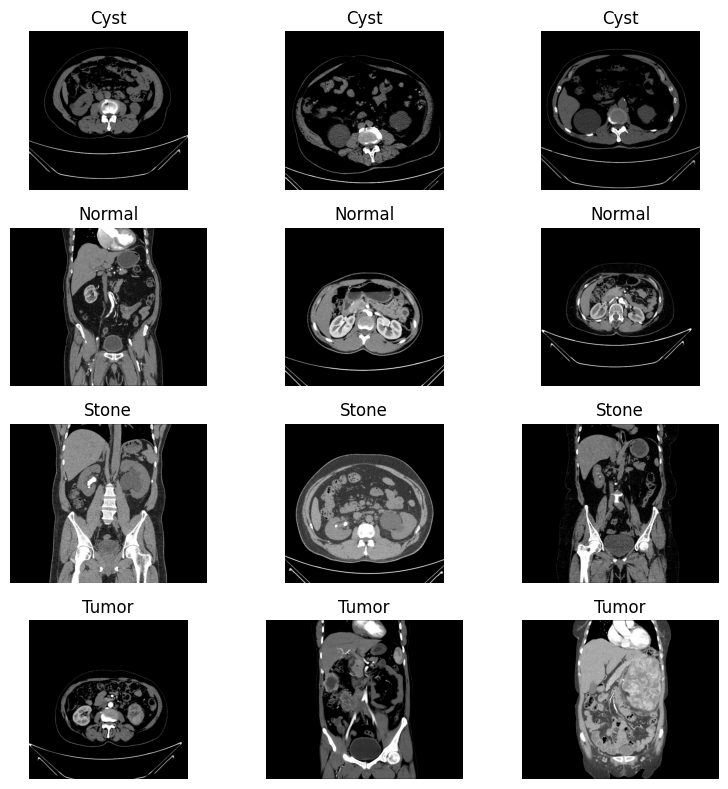

In [ ]:
# Display pictures on different classes of the dataset
classes_to_display = ['Cyst', 'Normal', 'Stone', 'Tumor']
fig, axes = plt.subplots(4, 3, figsize=(8, 8))
axes = axes.flatten()

for i, label in enumerate(classes_to_display):
    class_data = df[df['label'] == label]
    sample_images = random.sample(list(class_data['image_path']), 3)

    for j, img_path in enumerate(sample_images):
        img = mpimg.imread(img_path)
        axes[i * 3 + j].imshow(img)
        axes[i * 3 + j].axis('off')
        axes[i * 3 + j].set_title(label)
plt.tight_layout()
plt.show()

<ipython-input-12-4b9b9a2e50bc>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set3')


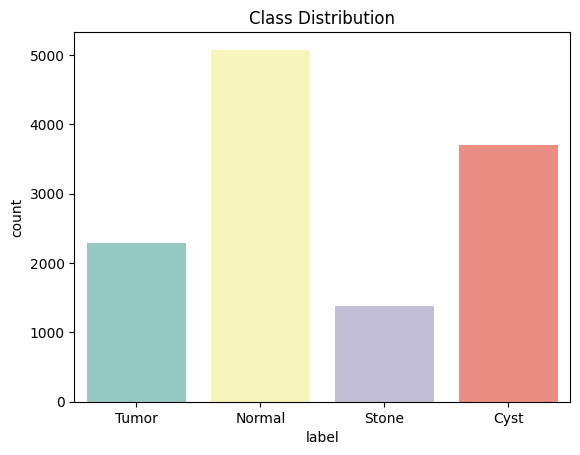

In [ ]:
# Compare the count of the 4 classes (tumor, stone, cyst, normal) in a bar chart
sns.countplot(x='label', data=df, palette='Set3')
plt.title('Class Distribution')
plt.show()

In [6]:
# Count of each category of label
class_counts=df['label'].value_counts()
print(class_counts)

# Find the maximum class size
max_size = class_counts.max()

# Separate each class
dfs = {label: df[df['label'] == label] for label in df['label'].unique()}

label
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64


In [7]:
# Define an image augmentation function
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image

# Augment images in smaller classes
augmented_data = []
for label, data in dfs.items():
    if len(data) < max_size:
        additional_samples = max_size - len(data)
        for i in range(additional_samples):
            original_image_path = random.choice(data['image_path'].tolist())
            img = tf.keras.preprocessing.image.load_img(original_image_path, target_size=(224, 224))
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = augment_image(img).numpy()
            augmented_data.append({'image_path': None, 'label': label, 'augmented_image': img})

# Add augmented data to the dataset
augmented_df = pd.DataFrame(augmented_data)
balanced_df = pd.concat([df, augmented_df])

label
Tumor     5077
Normal    5077
Stone     5077
Cyst      5077
Name: count, dtype: int64


<ipython-input-9-fae6986c4612>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=balanced_df, palette='Set3')


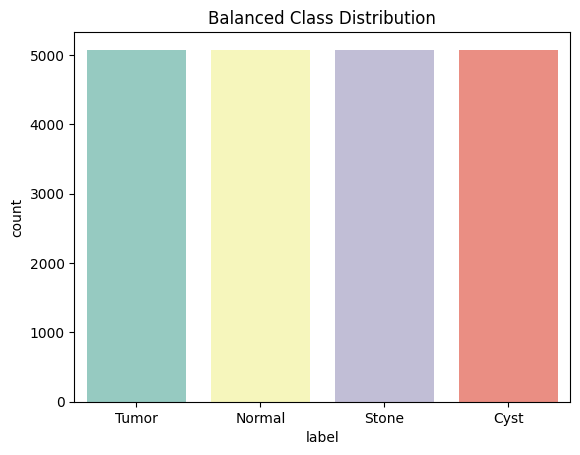

In [ ]:
# Check the distribution of classes after balancing
balanced_counts = balanced_df['label'].value_counts()
print(balanced_counts)

# Visualize the new distribution
sns.countplot(x='label', data=balanced_df, palette='Set3')
plt.title('Balanced Class Distribution')
plt.show()

In [8]:
# Split the dataset into train, test and validation sets
train_df, temp_df = train_test_split(balanced_df, test_size=0.3, stratify=balanced_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Print the number of samples in each set
print("Training set:")
print(train_df['label'].value_counts())
print("\nValidation set:")
print(val_df['label'].value_counts())
print("\nTest set:")
print(test_df['label'].value_counts())

Training set:
label
Cyst      3554
Tumor     3554
Normal    3554
Stone     3553
Name: count, dtype: int64

Validation set:
label
Stone     762
Cyst      762
Tumor     761
Normal    761
Name: count, dtype: int64

Test set:
label
Stone     762
Normal    762
Tumor     762
Cyst      761
Name: count, dtype: int64


In [9]:
# Image preprocessing
def preprocess_images(df, target_size=(64, 64)):
    images = []
    labels = []
    for _, row in df.iterrows():
        # If it's augmented data
        if row['image_path'] is None:
            img = row['augmented_image']
        else:
            img = tf.keras.preprocessing.image.load_img(row['image_path'], target_size=target_size)
            img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0

        # Ensure that the image has the correct shape (64, 64, 3)
        if img.shape != (64, 64, 3):
            img = np.resize(img, (64, 64, 3))

        images.append(img)
        labels.append(row['label'])

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Preprocess datasets
train_images, train_labels = preprocess_images(train_df)
val_images, val_labels = preprocess_images(val_df)
test_images, test_labels = preprocess_images(test_df)

In [10]:
# One-hot encoding of classes in train, test and validation datasets
encoder = LabelEncoder()
train_labels_encoded = to_categorical(encoder.fit_transform(train_labels))
val_labels_encoded = to_categorical(encoder.transform(val_labels))
test_labels_encoded = to_categorical(encoder.transform(test_labels))

In [11]:
# Function to compile and train models
def compile_and_train(model, train_images, train_labels, val_images, val_labels, epochs=20, batch_size=32):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_images, train_labels,
        epochs=epochs,
        validation_data=(val_images, val_labels),
        batch_size=batch_size
    )
    return history

In [12]:
# Function to plot training history
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

In [13]:
# Define the ANN model
ann_model = models.Sequential([
    layers.Flatten(input_shape=(64, 64, 3)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Define CNN model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Load the ResNet50 model with pre-trained ImageNet weights, exclude the top fully connected layers
base_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers of ResNet50 to keep the pre-trained weights intact
for layer in base_model1.layers[-10:]:
    layer.trainable = False

# Build the model on top of the base ResNet50 model
resnet50_model = models.Sequential([
    base_model1,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [16]:
# Load VGG16 with pre-trained ImageNet weights, exclude the top fully connected layers
base_model2 = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers of VGG16
for layer in base_model2.layers[-10:]:
    layer.trainable = False

# Build the model on top of the base VGG16 model
vgg16_model = models.Sequential([
    base_model2,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# Load DenseNet-121 with pre-trained ImageNet weights, excluding the top fully connected layers
base_model3 = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Unfreeze the last few layers for fine-tuning
for layer in base_model3.layers[-10:]:
    layer.trainable = False

# Build the DenseNet-121 model
densenet_model = models.Sequential([
    base_model3,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Epoch 1/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6152 - loss: 0.9558 - val_accuracy: 0.8638 - val_loss: 0.3453
Epoch 2/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8167 - loss: 0.4345 - val_accuracy: 0.8933 - val_loss: 0.2670
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8406 - loss: 0.3618 - val_accuracy: 0.8923 - val_loss: 0.2476
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8511 - loss: 0.3237 - val_accuracy: 0.9015 - val_loss: 0.2352
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8477 - loss: 0.3318 - val_accuracy: 0.8946 - val_loss: 0.2266
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8604 - loss: 0.2995 - val_accuracy: 0.8979 - val_loss: 0.2218
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8690 - loss: 0.2849 - val_accuracy: 0.8963 - val_loss: 0.2212
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8664 - loss: 0.2912 - val_accuracy: 0.

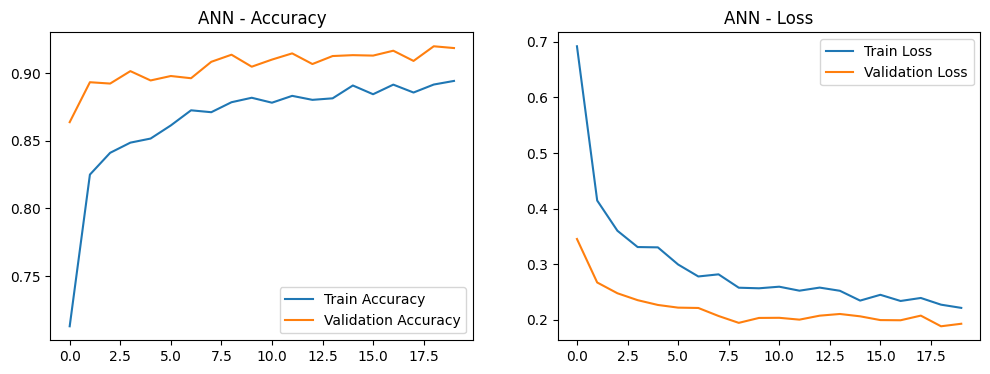

In [ ]:
# Train ANN model
ann_history = compile_and_train(ann_model, train_images, train_labels_encoded, val_images, val_labels_encoded)

# Plot accuracy and loss from training ANN model
plot_training_history(ann_history, 'ANN')

#Save ANN model
ann_model.save('/content/ann_model.h5')

Epoch 1/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5339 - loss: 1.0194 - val_accuracy: 0.8457 - val_loss: 0.3783
Epoch 2/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8520 - loss: 0.3413 - val_accuracy: 0.8828 - val_loss: 0.2535
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8954 - loss: 0.2321 - val_accuracy: 0.9022 - val_loss: 0.2181
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9015 - loss: 0.2057 - val_accuracy: 0.9048 - val_loss: 0.2063
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9109 - loss: 0.1875 - val_accuracy: 0.9120 - val_loss: 0.2146
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9151 - loss: 0.1799 - val_accuracy: 0.9150 - val_loss: 0.1848
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9187 - loss: 0.1721 - val_accuracy: 0.9077 - val_loss: 0.2031
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9241 - loss: 0.1580 - val_accuracy:

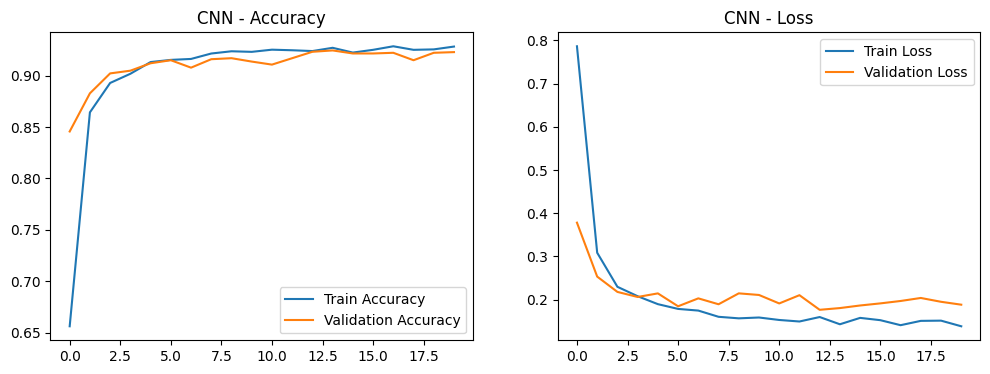

In [ ]:
# Train CNN model
cnn_history = compile_and_train(cnn_model, train_images, train_labels_encoded, val_images, val_labels_encoded)

# Plot accuracy and loss from training CNN model
plot_training_history(cnn_history, 'CNN')

# Save CNN model
cnn_model.save('/content/cnn_model.h5')

Epoch 1/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 116s 132ms/step - accuracy: 0.6453 - loss: 0.9432 - val_accuracy: 0.2502 - val_loss: 2.1910
Epoch 2/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.8344 - loss: 0.4154 - val_accuracy: 0.4649 - val_loss: 2.2633
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - accuracy: 0.8765 - loss: 0.2876 - val_accuracy: 0.8854 - val_loss: 0.2852
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.8928 - loss: 0.2409 - val_accuracy: 0.8943 - val_loss: 0.2691
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.8859 - loss: 0.2768 - val_accuracy: 0.9022 - val_loss: 0.2264
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.8938 - loss: 0.2610 - val_accuracy: 0.9160 - val_loss: 0.1768
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.9116 - loss: 0.2056 - val_accuracy: 0.9130 - val_loss: 0.2004
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.9144 - loss: 0.1710 

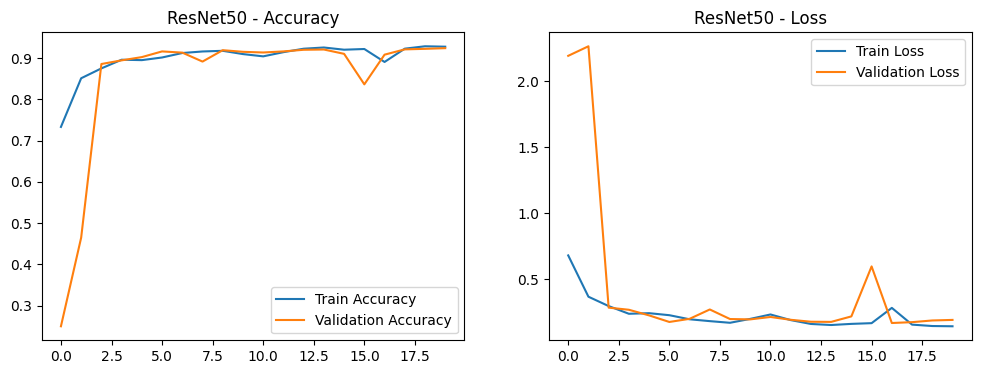

In [ ]:
# Train ResNet50 model
resnet50_history = compile_and_train(resnet50_model, train_images, train_labels_encoded, val_images, val_labels_encoded)

# PLot accuracy and loss from training ResNet50 model
plot_training_history(resnet50_history, 'ResNet50')

# Save ResNet50 model
resnet50_model.save('/content/resnet50_model.h5')

Epoch 1/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.4553 - loss: 1.1770 - val_accuracy: 0.6267 - val_loss: 0.7850
Epoch 2/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.6465 - loss: 0.7923 - val_accuracy: 0.7091 - val_loss: 0.5828
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.7174 - loss: 0.6264 - val_accuracy: 0.7587 - val_loss: 0.6460
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.7522 - loss: 0.5864 - val_accuracy: 0.8194 - val_loss: 0.4133
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.8034 - loss: 0.4462 - val_accuracy: 0.8381 - val_loss: 0.3761
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.8368 - loss: 0.3691 - val_accuracy: 0.7843 - val_loss: 0.5093
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.8418 - loss: 0.3561 - val_accuracy: 0.8628 - val_loss: 0.2882
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.8581 - loss: 0.3148 - 

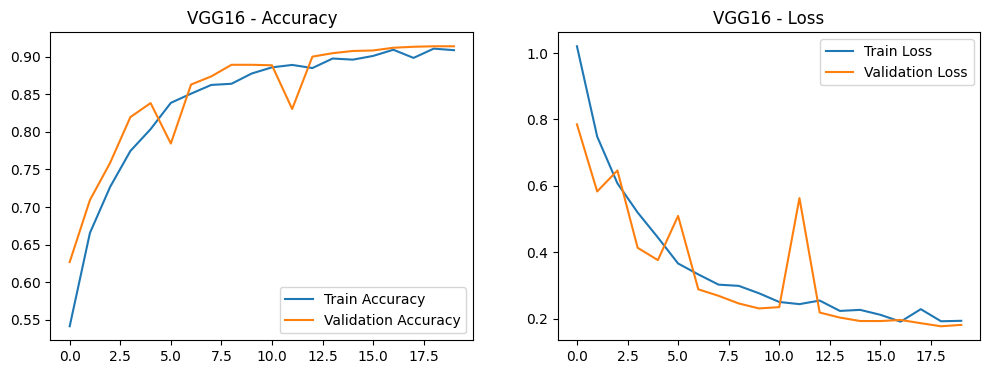

In [ ]:
# Train VGG16 model
vgg16_history = compile_and_train(vgg16_model, train_images, train_labels_encoded, val_images, val_labels_encoded)

# Plot accuracy and loss from training VGG16 model
plot_training_history(vgg16_history, 'VGG16')

# Save VGG16 model
vgg16_model.save('/content/vgg16_model.h5')

Epoch 1/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 274s 296ms/step - accuracy: 0.6219 - loss: 0.9195 - val_accuracy: 0.7905 - val_loss: 0.5292
Epoch 2/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.7956 - loss: 0.5060 - val_accuracy: 0.8464 - val_loss: 0.3699
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.8537 - loss: 0.3579 - val_accuracy: 0.8588 - val_loss: 0.3468
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.8744 - loss: 0.2835 - val_accuracy: 0.8644 - val_loss: 0.4158
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.8781 - loss: 0.2869 - val_accuracy: 0.8011 - val_loss: 0.6416
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 43s 59ms/step - accuracy: 0.8878 - loss: 0.2545 - val_accuracy: 0.7672 - val_loss: 1.7848
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.8774 - loss: 0.2780 - val_accuracy: 0.9015 - val_loss: 0.2293
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.8966 - loss: 0.2459 

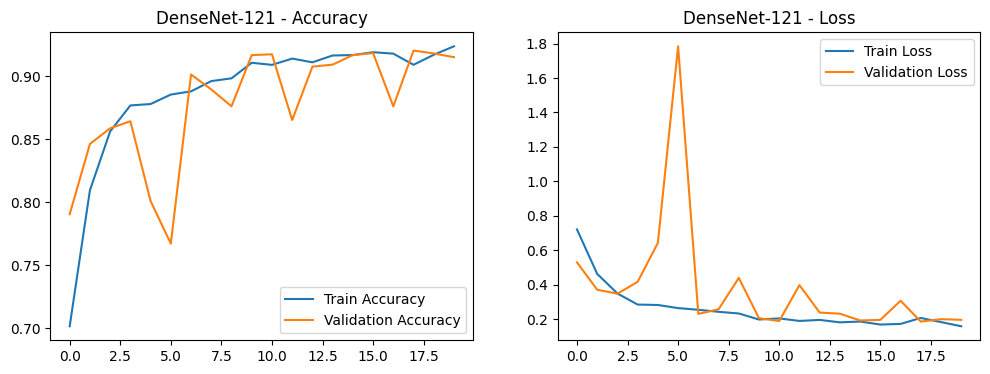

In [ ]:
# Train DenseNet-121 model
densenet_history = compile_and_train(densenet_model, train_images, train_labels_encoded, val_images, val_labels_encoded)

# Plot accuracy and loss from training DenseNet-121 model
plot_training_history(densenet_history, 'DenseNet-121')

# Save DenseNet-121 model
densenet_model.save('/content/densenet_model.h5')

In [ ]:
# Evaluation of the models
cnn_accuracy = cnn_model.evaluate(test_images, test_labels_encoded)
ann_accuracy = ann_model.evaluate(test_images, test_labels_encoded)
vgg16_accuracy = vgg16_model.evaluate(test_images, test_labels_encoded)
resnet50_accuracy = resnet50_model.evaluate(test_images, test_labels_encoded)
densenet121_accuracy = densenet_model.evaluate(test_images, test_labels_encoded)

print(f"ANN Accuracy: {ann_accuracy[1]:.4f}")
print(f"CNN Accuracy: {cnn_accuracy[1]:.4f}")
print(f"ResNet50 Accuracy: {resnet50_accuracy[1]:.4f}")
print(f"VGG16 Accuracy: {vgg16_accuracy[1]:.4f}")
print(f"DenseNet-121 Accuracy: {densenet121_accuracy[1]:.4f}")

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9232 - loss: 0.2026
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9175 - loss: 0.2105
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9100 - loss: 0.1977
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9215 - loss: 0.2301
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.9205 - loss: 0.1854
ANN Accuracy: 0.9209
CNN Accuracy: 0.9258
ResNet50 Accuracy: 0.9245
VGG16 Accuracy: 0.9107
DenseNet-121 Accuracy: 0.9189


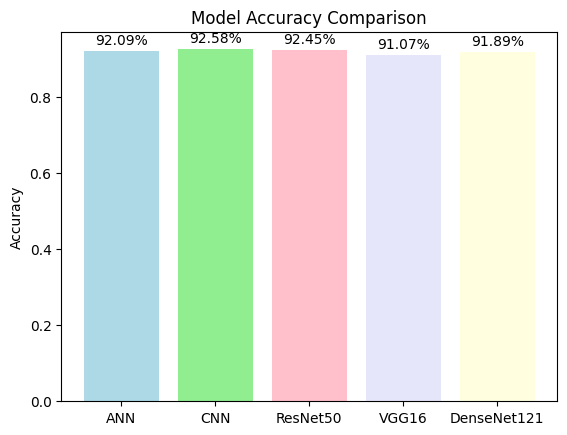

In [ ]:
# Comparison chart
accuracies = [ann_accuracy[1],cnn_accuracy[1], resnet50_accuracy[1], vgg16_accuracy[1], densenet121_accuracy[1]]
dl_models = ['ANN','CNN', 'ResNet50', 'VGG16','DenseNet121']

plt.bar(dl_models, accuracies, color=['lightblue','lightgreen','pink','lavender','lightyellow'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')

# Add text on top of the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.01, f'{accuracy * 100:.2f}%', ha='center', va='bottom')

plt.show()

In [ ]:
# Install keras-tuner for hyperparameter tuning
!pip install keras-tuner
import keras_tuner as kt

In [ ]:
# Define the model-building function for KerasTuner
def build_model(hp):
    model = models.Sequential([
        layers.Conv2D(
            filters=hp.Choice('filters_1', [32, 64]),
            kernel_size=(3, 3),
            activation='relu',
            input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(
            filters=hp.Choice('filters_2', [64, 128]),
            kernel_size=(3, 3),
            activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(
            filters=hp.Int('filters_3', 128, 256, step=64),
            kernel_size=(3, 3),
            activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(
            units=hp.Int('dense_units', 64, 256, step=64),
            activation='relu'),
        layers.Dropout(hp.Float('dropout_rate', 0.3, 0.6, step=0.1)),
        layers.Dense(4, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='/content/hyperparam_tuning',
    project_name='cnn_tuning')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
# Perform the search
tuner.search(
    train_images, train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=20,
    callbacks=[stop_early])

Trial 30 Complete [00h 01m 40s]
val_accuracy: 0.9235062599182129

Best val_accuracy So Far: 0.9310570955276489
Total elapsed time: 00h 21m 00s


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of filters in the first Conv2D layer is {best_hps.get('filters_1')}
and in the second Conv2D layer is {best_hps.get('filters_2')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


The optimal number of filters in the first Conv2D layer is 32
and in the second Conv2D layer is 128.
The optimal learning rate is 0.0005.



In [ ]:
# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_images, train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=20
)

Epoch 1/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.6208 - loss: 0.8971 - val_accuracy: 0.8431 - val_loss: 0.3792
Epoch 2/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8527 - loss: 0.3346 - val_accuracy: 0.9038 - val_loss: 0.2274
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8942 - loss: 0.2299 - val_accuracy: 0.9107 - val_loss: 0.1987
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9075 - loss: 0.1939 - val_accuracy: 0.9146 - val_loss: 0.1975
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9144 - loss: 0.1787 - val_accuracy: 0.9225 - val_loss: 0.1748
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9214 - loss: 0.1610 - val_accuracy: 0.9215 - val_loss: 0.1873
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9228 - loss: 0.1612 - val_accuracy: 0.8930 - val_loss: 0.2037
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9191 - loss: 0.1589 - val_accuracy:

In [ ]:
# Evaluate the best model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels_encoded, verbose=0)
print(f"Best Model Test Accuracy: {test_accuracy:.4f}")

# Save the best model
best_model.save('/content/best_cnn_model.h5')

Best Model Test Accuracy: 0.9189


In [ ]:
m=load_model('/content/ann_model.h5')

In [ ]:
# Function to preprocess a single image
def preprocess_image(image, target_size=(64, 64,3)):
    image=np.resize(image,target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to predict the class of a new image
def predict_image_class(image):
    img_array = preprocess_image(image)
    predictions = m.predict(img_array)
    class_index = np.argmax(predictions)
    class_name = encoder.inverse_transform([class_index])[0]
    class_probability = predictions[0][class_index]
    return class_name,class_probability

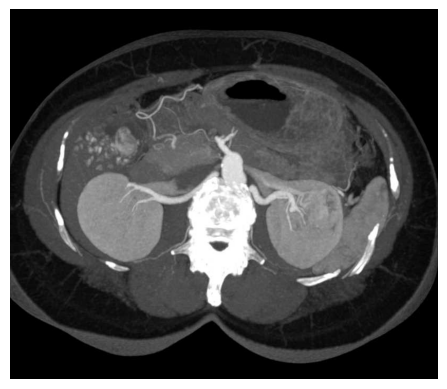

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


('Stone', 0.45417422)

In [ ]:
# Predicting a new image
new_image_path = '/content/390569.jpg'
new_image = plt.imread(new_image_path)

plt.imshow(new_image,cmap='grey')
plt.axis('off')
plt.show()

predict_image_class(new_image)